连续特征(continuous feature),离散特征(discrete feature),对于某个特定应用来说，如何找到最佳数据表示，这个问题被称为特征工程，用正确的方式表示数据，对监督模型性能的影响比所选择的精确参数还要大。

# 4.1分类变量

# 4.1.1One-Hot编码或N取一编码(虚拟变量)

虚拟变量背后的思想是将一个分类变量替换为一个或多个新特征，新特征取值为0和1.
用pandas编码数据有一种非常简单的方法，使用get_dummies函数

读取完数据集之后，最好先检查每一列是否包含有意义的分类数据，使用pd.value_counts函数，以显示唯一值和出现次数。

我们对同时包含训练数据和测试数据的数据框调用get_dummies很重要，可以确保训练集和测试集中分类变量的表示方法相同

# 4.1.2数字可以编码分类变量

pandas的get_dummies函数将所有数字看作是连续的，不会为其创建虚拟变量，为了解决这个问题，可以使用scikit-learn中的OneHotEncoder，指定哪些变量是连续的哪些变量是离散的，你也可以将数据框中的数值列转换为字符串

In [1]:
import pandas as pd
demo_df = pd.DataFrame({'Integer Feature': [0, 1, 2, 1],
                        'Categorical Feature': ['socks', 'fox', 'socks', 'box']})
display(demo_df)

,Integer Feature,Categorical Feature
0,0,socks
1,1,fox
2,2,socks
3,1,box


In [2]:
pd.get_dummies(demo_df)
#使用get_dummies只会编码字符串特征，不会改变整数特征

,Integer Feature,Categorical Feature_box,Categorical Feature_fox,Categorical Feature_socks
0,0,0,0,1
1,1,0,1,0
2,2,0,0,1
3,1,1,0,0


In [3]:
pd.get_dummies(demo_df,columns=['Integer Feature','Categorical Feature'])
#显示地给出想要编码的列，于是两个特征都会被当分类特征处理

,Integer Feature_0,Integer Feature_1,Integer Feature_2,Categorical Feature_box,Categorical Feature_fox,Categorical Feature_socks
0,1,0,0,0,0,1
1,0,1,0,0,1,0
2,0,0,1,0,0,1
3,0,1,0,1,0,0


# 4.2分箱，离散化，线性模型与树

数据最佳的表示方法不仅取决于数据的语义，还取决于所使用的模型种类。
有一种方法可以让线性模型在连续数据上变得更强大，就是使用特征分箱，将其划分为多个特征。
因为每个箱子内的特征是不变得，所以对于一个箱子内的所有点，任何模型都会预测相同的值。
分箱通常针对的是单个特征，线性模型的表现力在数据变换后的到了极大的提高。

如果有充分理由使用线性模型——比如数据集很大，维度很高，但有些特征与输出的关系是非线性的，那么分箱是提高建模能力的好方法

In [4]:
import numpy as np
bins=np.linspace(-3,3,11)
bins

array([-3. , -2.4, -1.8, -1.2, -0.6,  0. ,  0.6,  1.2,  1.8,  2.4,  3. ])

# 4.3交互特征和多项式特征

想要丰富特征表示，特别是对于线性模型而言，另一种方法是添加原始数据的交互特征（interaction feature）
和多项式特征（polynomial feature）

想要向分箱数据上的线性模型添加斜率，一种方法是重新加入原始特征，只有一个x轴特征也就只有一个斜率。

为了每个箱子有不同的斜率，我们可以添加交互特征或乘积特征。

使用分箱是扩展连续特征的一种方法，另一种方法是使用原始特征的多项式

In [6]:
from sklearn.datasets import load_boston
boston=load_boston()
x=boston.data
y=boston.target
#读取boston房价数据 进行回归预测 13特征
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=9)
#将数据随机分割成训练集和测试集
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaler.fit(x_train)
x_train_scaled=scaler.transform(x_train)
x_test_scaled=scaler.transform(x_test)
#合并一步缩放
from sklearn.preprocessing import PolynomialFeatures
poly= PolynomialFeatures(degree=2)
x_train_poly=poly.fit_transform(x_train_scaled)
x_test_poly=poly.fit_transform(x_test_scaled)

In [7]:
print("x_train_scaled shape:"+str(x_train_scaled.shape))
print("x_train_poly shape:"+str(x_train_poly.shape))

x_train_scaled shape:(379, 13)
x_train_poly shape:(379, 105)


In [8]:
#对比交互特征和没有交互特征数据上性能
from sklearn.linear_model import Ridge
ridge=Ridge().fit(x_train_scaled,y_train)
print("score without interaction"+str(ridge.score(x_test_scaled,y_test)))
ridge=Ridge().fit(x_train_poly,y_train)
print("score with interaction"+str(ridge.score(x_test_poly,y_test)))

score without interaction0.7611126113880906
score with interaction0.8824465250357664


对于简单的线性模型，交互特征和多项式对性能提升有很大帮助

In [9]:
from sklearn.ensemble import RandomForestRegressor
rfr=RandomForestRegressor(n_estimators=100).fit(x_train_scaled,y_train)
print("score without interaction"+str(rfr.score(x_test_scaled,y_test)))
rfr=RandomForestRegressor(n_estimators=100).fit(x_train_poly,y_train)
print("score with interaction"+str(rfr.score(x_test_poly,y_test)))

score without interaction0.8627125016532299
score with interaction0.9022865913896603


对于复杂的模型，交互特征和多项式对性能提升有限

# 4.4单变量非线性变换

应用数学函数比如log，exp或sin。虽然基于树的模型只关注特征的顺序，但线性模型和神经网络依赖于每个特征的尺度和分布，log和exp函数可以帮助调节数据的相对比例。在处理具有周期性模式的数据时，sin和cos函数非常有用。

In [10]:
import numpy as np
rnd = np.random.RandomState(0)
x_org = rnd.normal(size=(1000, 3))
w = rnd.normal(size=3)
x = rnd.poisson(10 * np.exp(x_org))
y = np.dot(x_org, w)

In [12]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)
score = Ridge().fit(x_train, y_train).score(x_test, y_test)
score

0.6224186236310756

In [14]:
x_train_log=np.log(x_train+1)
x_test_log=np.log(x_test+1)
score=Ridge().fit(x_train_log,y_train).score(x_test_log,y_test)
score

0.8749342372887815

为数据集和模型的所有组合寻找最佳变换，是门艺术

# 4.5自动化特征选择

在添加新特征或处理一般的高维数据集时，最好将特征的数量减少到只包含最有用的那些特征，并删除其余特征，这样会得到泛化能力更好，更简单的模型。

# 4.5.1单变量统计(univariate statistics)

在单变量统计中，我们计算每个特征和目标值之间的关系是否存在统计显著性，然后选择具有最高置信度的特征。它完全独立于你可能想要在特征选择之后应用的模型

我们将分类的特征选择应用于cancer数据集。为了使任务更难一点，我们将向数据中添加一些没有信息量的噪声特征。我们期望特征选择能够识别没有信息量的特征并删除它们

In [18]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import SelectPercentile
#from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
cancer=load_breast_cancer()

#获得确定性随机数
rng = np.random.RandomState(42)
noise = rng.normal(size=(len(cancer.data), 50))
# 向数据中添加噪声特征
# 前30个特征来自数据集，后50个是噪声
x_noise = np.hstack([cancer.data, noise])

x_train, x_test, y_train, y_test = train_test_split(
    x_noise, cancer.target, random_state=0, test_size=.5)
# use f_classif (the default) and SelectPercentile to select % of features
#选择50%的特征
#score_func默认f_classif
select = SelectPercentile(percentile=50)
#对训练集进行训练
select.fit(x_train,y_train)
# 对训练集进行变换
x_train_selected = select.transform(x_train)

print("x_train.shape: {}".format(x_train.shape))
print("x_train_selected.shape: {}".format(x_train_selected.shape))

x_train.shape: (284, 80)
x_train_selected.shape: (284, 40)


In [14]:
from sklearn.feature_selection import SelectKBest
select=SelectKBest(score_func=mutual_info_classif,k=30)
#score_func选择主要有5种，mutual_info_regression,f_classif,f_regression,chi2
#K表示选择p值较小的K个特征
select.fit(x_train,y_train)
x_train_selected=select.transform(x_train)
print("x_train.shape: {}".format(x_train.shape))
print("x_train_selected.shape: {}".format(x_train_selected.shape))

x_train.shape: (284, 80)
x_train_selected.shape: (284, 30)


In [19]:
mask=select.get_support()
print(mask)
#看哪些特征被选中

[ True  True  True  True  True  True  True  True  True False  True False
  True  True  True  True  True  True False False  True  True  True  True
  True  True  True  True  True  True False False False  True False  True
 False False  True False False False False  True False False  True False
 False  True False  True False False False False False False  True False
  True False False False False  True False  True False False False False
  True  True False  True False False False False]


Text(0.5, 0, 'Sample Index')

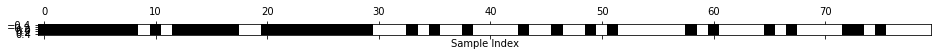

In [20]:
import matplotlib.pyplot as plt
plt.matshow(mask.reshape(1,-1),cmap='gray_r')
plt.xlabel("Sample Index")
#黑色为true，白色为false

大多数所选择的特征都是原始特征，并且大多数噪声特征都已被删除，但原始特征还原不完美

In [21]:
import warnings;warnings.simplefilter('ignore')
from sklearn.linear_model import LogisticRegression
x_test_selected=select.transform(x_test)
lr=LogisticRegression()
lr.fit(x_train,y_train)
print("score with all features:"+str(lr.score(x_test,y_test)))
lr.fit(x_train_selected,y_train)
print("score with selected features:"+str(lr.score(x_test_selected,y_test)))

score with all features:0.9298245614035088
score with selected features:0.9403508771929825


删除噪声可以提高性能，如果特征量太大以至于无法构建模型，或者许多特征完全没有信息量，那么单变量特征选择还是有用的

# 4.5.2基于模型的特征选择(model_based selection)

基于模型的特征选择使用一个监督机器学习模型来判断每个特征的重要性，并且仅保留最重要的特征。用于特征选择的监督模型不需要与用于最终监督建模的模型相同。与单变量选择不同，基于模型的选择同时考虑所有特征，因此可以获取交互项。

In [22]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
select = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42),threshold="median")

In [23]:
select.fit(x_train,y_train)
x_train_l1=select.transform(x_train)
x_train_l1.shape

(284, 40)

Text(0.5, 0, 'Sample Index')

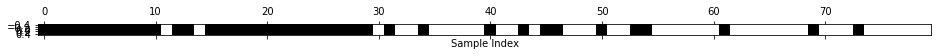

In [24]:
mask=select.get_support()
import matplotlib.pyplot as plt
plt.matshow(mask.reshape(1,-1),cmap='gray_r')
plt.xlabel("Sample Index")
#黑色为true，白色为false

In [25]:
x_test_l1=select.transform(x_test)
lr.fit(x_train_l1,y_train).score(x_test_l1,y_test)

0.9543859649122807

这次除了两个原始特征，其他原始特征都被选中，性能也得到了提高

# 4.5.3迭代特征选择(iterative selection)

在迭代特征选择中，将会构建一系列模型，每个模型都使用不同数量的特征。其中一种特殊方法是递归特征消除，它从所有特征开始构建模型，并根据模型舍弃最不重要的特征，然后使用被舍弃特征之外的所有特征来构建一个新模型，如此继续，直到仅剩下预设数量的特征。

Text(0.5, 0, 'Sample Index')

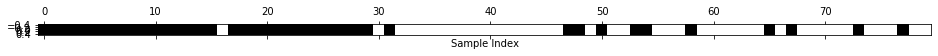

In [26]:
from sklearn.feature_selection import RFE
select=RFE(RandomForestClassifier(n_estimators=100, random_state=42),n_features_to_select =40)
select.fit(x_train,y_train)
mask=select.get_support()
import matplotlib.pyplot as plt
plt.matshow(mask.reshape(1,-1),cmap='gray_r')
plt.xlabel("Sample Index")

与单变量选择和基于模型的选择相比，迭代特征选择的结果更好，但仍然漏掉了一个特征

In [29]:
x_train_rfe=select.transform(x_train)
x_test_rfe=select.transform(x_test)
from sklearn.linear_model import LogisticRegression
LogisticRegression().fit(x_train_rfe,y_train).score(x_test_rfe,y_test)

0.9508771929824561

在大多数情况下，使用特征选择不大可能大幅提升性能，但它仍是特征工程工具箱中一个非常有价值的工具

# 4.6利用专家知识

利用这种方法可以将关于任务属性的先验知识编码到特征中，以辅助机器学习算法。添加一个特征并不会强制机器学习算法使用它。